In [1]:
import numpy as np
from sklearn.datasets import load_iris, fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
class MLP(object):
    
    def __init__(self,hidden:int=10, epochs:int=100, eta:float=0.1, shuffle:bool=True,
                 nfeatures:int=4, nclasses:int=3):
        """
        hidden: liczba ukrytych neuronów
        epochs: liczba kroków prezentacji próbek zestawów treningowych
        eta: współczynnik uczenia
        shuffle: miesza dane uczące w każdej epoce 
        """
        self.__hidden=hidden
        self.__epochs = epochs
        self.__eta =eta
        self.__shuffle = shuffle
        self.__nfeatures =nfeatures
        self.__nclasses = nclasses
        self.costOfEpoch = []
        self.accuracyOfEpoch = []
    
    def __sigmoid(self,z):
        """
        oblicza funkcję logistyczną jako funkcję transferu
        """
        return 1/(1+ np.exp(-z))
    
    def __forward(self,X):
        outputHiddenNeurons = self.__calculateAdderOfHiddenLayer(X) # krok 1
        sigmoidHiddenLayer = self.__calculateSigmoidOnHiddenNeurons(outputHiddenNeurons) # krok 2
        outputNeurons = self.__calculateAdderOfOutputLayer(sigmoidHiddenLayer) # krok 3
        sigmoidOutputLayer = self.__calculateSigmoidOnOutputNeurons(outputNeurons) # krok 4
        return sigmoidHiddenLayer, sigmoidOutputLayer # zwraca wyjścia z warstwy ukrytej i wartstwy wyjściowej
        
    def __calculateAdderOfHiddenLayer(self,X):
        return np.dot(X, self.w_h) + self.b_h
    
    def __calculateSigmoidOnHiddenNeurons(self,outputHiddenNeurons):
        return self.__sigmoid(outputHiddenNeurons)
        
    
    def __calculateAdderOfOutputLayer(self,outputHiddenNeurons):
        return np.dot(outputHiddenNeurons, self.w_out) + self.b_out
    
    def __calculateSigmoidOnOutputNeurons(self,outputNeurons):
        return self.__sigmoid(outputNeurons)
    
    def __compute_cost(self,y,output):
        numberOfElements =  len(y)
        total = 0
        for i in range(numberOfElements):
            inner_sum = 0
            for k in range(self.__nclasses):
                inner_sum += y[i][k] * np.log(output[i][k]) + (1 - y[i][k]) * np.log(1 - output[i][k] )
            total += inner_sum
        return -total
        return 0
        

    def fit(self,X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.__initializeWeightsAndBiases() # Krok 1
        for epoch in range(self.__epochs): # Krok 2
            if self.__shuffle:
                self.__shuffleTestData() # i
            for X, y  in zip( self.X_train, self.y_train): # ii
                sigmoidHiddenLayer, sigmoidOutputLayer  = self.__forward(X) # iii
                self.__backward( X,y, sigmoidHiddenLayer, sigmoidOutputLayer)# iv
            cost,accuracy = self.__summaryOfEpoch(sigmoidOutputLayer) # v
            self.costOfEpoch.append(cost)
            self.accuracyOfEpoch.append(accuracy)
            #self.__showSummary(cost,accuracy, epoch) # vi
        return self.costOfEpoch, self.accuracyOfEpoch
        
    def __initializeWeightsAndBiases(self):
        self.__initializeHiddenLayerWeight()
        self.__initializeHiddenLayerBiases()
        
    def __initializeHiddenLayerWeight(self):
        """
        inicjalizowanie liczbami:
        dla wag w => losowymi z rozkładu normalnego o średniej 0 i odchyleniu standardowym 0.1
        """
        loc =0
        scale = 0.1
        self.w_h = np.random.normal(loc,scale, size=(self.__nfeatures, self.__hidden) )        
        self.w_out = np.random.normal(loc,scale, size=( self.__hidden, self.__nclasses) )
        
    def __initializeHiddenLayerBiases(self):
        self.b_h = np.zeros(self.__hidden)
        self.b_out = np.zeros(self.__nclasses)
    
    def __shuffleTestData(self):
        shuffledData = list(zip(self.X_train,self.y_train))
        np.random.shuffle(shuffledData)
        self.X_train,self.y_train = zip(*shuffledData)
        
    
    def __backward(self,X,y, sigmoidHiddenLayer, sigmoidOutputLayer):
        derivativeOutputLayer = self.__derivative(sigmoidOutputLayer) # A 
        deltaOut = self.__calculateDeltaOut(sigmoidOutputLayer,y, derivativeOutputLayer) # B 
        
        derivativeHiddenLayer = self.__derivative(sigmoidHiddenLayer) # C  
        deltaHidden = self.__calculateDeltaHidden(deltaOut, derivativeHiddenLayer) # D 
        
        gradientWeigthHiddenLayer = self.__calculateGradient(X, deltaHidden) # E Error
        gradientHiddenBias = deltaHidden # F 
        gradientWeigthOutputLayer = self.__calculateGradient(sigmoidHiddenLayer, deltaOut) # G Error
        gradientOutBias = deltaOut # H 
        

        self.__setNewWeights(gradientWeigthHiddenLayer,gradientHiddenBias,
                             gradientWeigthOutputLayer,gradientOutBias) # I
     
    def __derivative(self,sigmoid): #pochodna funkcji aktywacji
        return sigmoid * (1-sigmoid)
    
    def __calculateDeltaOut(self, sigmoidOutputLayer, y, derivativeOutputLayer):
        return (sigmoidOutputLayer - y)* derivativeOutputLayer
    
    def __calculateDeltaHidden(self,deltaOut, derivativeHiddenLayer ):
        transpondedWeight = np.transpose(self.w_out)
        return np.dot(deltaOut, transpondedWeight)* derivativeHiddenLayer
    
    def __calculateGradient(self,inputData, delta):
        transposedInputData = np.transpose(inputData)
        return np.outer(transposedInputData, delta)
    
    def __setNewWeights(self,gradientWeigthHiddenLayer,gradientHiddenBias,gradientWeigthOutputLayer,gradientOutBias):
        self.w_h = self.w_h - gradientWeigthHiddenLayer * self.__eta
        self.b_h = self.b_h - gradientHiddenBias * self.__eta
        self.w_out = self.w_out - gradientWeigthOutputLayer * self.__eta
        self.b_out = self.b_out - gradientOutBias * self.__eta
            
    def __summaryOfEpoch(self,sigmoidOutputLayer):
        sigmoidHiddenLayer, sigmoidOutputLayer  = self.__forward(self.X_train)
        cost = self.__compute_cost(self.y_train, sigmoidOutputLayer)
        accuracy = self.accuracy_score(self.y_train, sigmoidOutputLayer) # sklearn.metrics
        return cost,accuracy
    
    def __showSummary(self,cost,accuracy, epoch):
        print("----------------------------------------------")
        print("{}. epoch   cost = {}, accuracy ={}".format(epoch,cost,accuracy))
        
    def predict(self,X_test):
        sigmoidHiddenLayer,sigmoidOutputLayer  = self.__forward(X)
        decodedOutput = self.__OneHotEncoderOfOutput(sigmoidOutputLayer)
        return decodedOutput
    
    def __OneHotEncoderOfOutput(self,yPredicted):
        coded_list = [
                [1., 0., 0.],
                [0., 1., 0.],
                [0., 0., 1.]
             ]
        yEncoded = []
        yPredictedArgMaxIndexes = np.argmax(yPredicted,1)
        for  maxIndex in yPredictedArgMaxIndexes:
            yEncoded.append(coded_list[maxIndex])
        return yEncoded
    
    def accuracy_score(self,yTrue, yPredicted):
        counter =0
        
        for true, predicted in zip(yTrue, yPredicted):
            #print("true", true)
            #print("pred", predicted)
            if self.__isLabelCorrect(true,predicted):
                counter +=1
        return counter/np.shape(yTrue)[0] * 100
    
    def __isLabelCorrect(self,true,predicted):
        return np.argmax(true) == np.argmax(predicted)
        
            
        

In [3]:
def drawLearningProcess(costOfEpoch, accuracyOfEpoch,epochs):
    print(".....................................................................................")
    print("Learning Completed")
    print("Number of epochs: {}".format(epochs))
    print("Cost of last epoch: {}".format(costOfEpoch[-1]))
    print("Accuracy of last epoch: {}".format(accuracyOfEpoch[-1]))
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    x = list(range(epochs))
    
    ax[0].plot(x,costOfEpoch, linestyle='--', marker='o')
    ax[0].set_title("Cost during learning of model")
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("cost")
    
    ax[1].plot(x,accuracyOfEpoch, linestyle='--', marker='o')
    ax[1].set_title("Accuracy during learning of model")
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("accuracy")
    
    plt.show()


.....................................................................................
Learning Completed
Number of epochs: 100
Cost of last epoch: 29.079813022693024
Accuracy of last epoch: 96.42857142857143


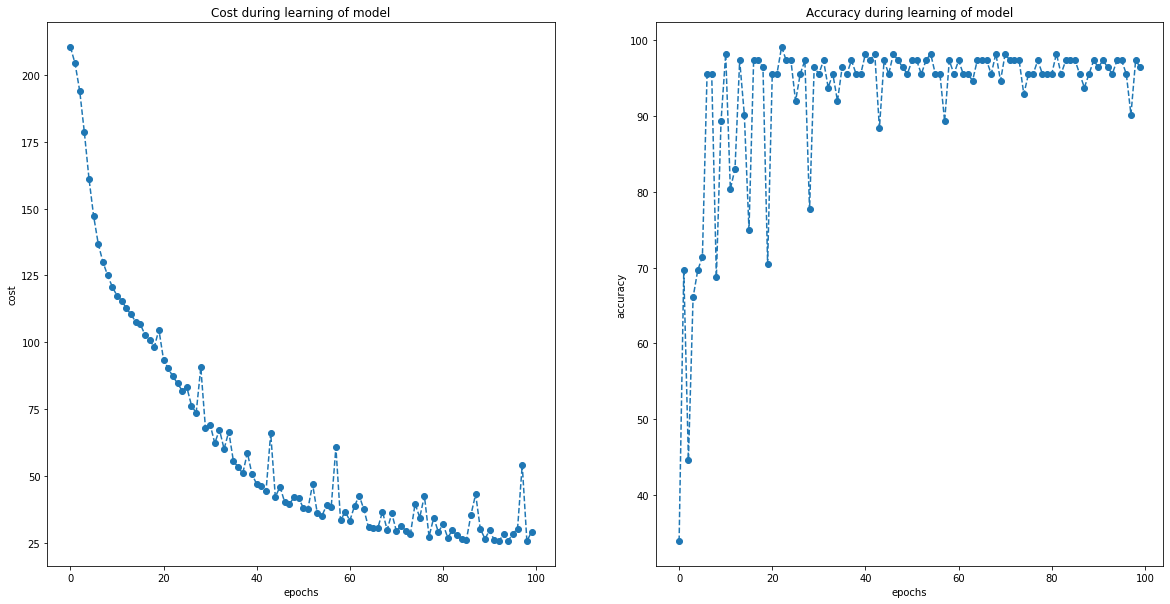

Accuracy of Test Dataset: 31.57894736842105


In [4]:
#ZADANIE 1
#GŁÓWNA CZĘŚĆ PROGRAMU
NFEATURES= 4 # ilość cech każdego obiektu

#1 wczytanie danych
X, y = fetch_openml(name="iris", version=1, return_X_y = True)
CLASSESNCOUNT = len(np.unique(y))
SAMPLESCOUNT = np.shape(X)[0]

#2 trasforamacja na macierz y_iris_coded
yIrisCoded = np.zeros((SAMPLESCOUNT,CLASSESNCOUNT))
iris_names = np.unique(y)
coded_list = [
                [1., 0., 0.],
                [0., 1., 0.],
                [0., 0., 1.]
             ]
for name, coded  in zip(iris_names, coded_list):
    yIrisCoded[y == name] = coded
    
#3. dokonać podziału na zbiór uczący i testujący
XTrain, XTest, yTrain, yTest = train_test_split(X, yIrisCoded, random_state=13)
epochs =100
mlp = MLP(epochs = epochs) #Utworzenie modelu MLP
costOfEpoch, accuracyOfEpoch = mlp.fit(XTrain,yTrain)

drawLearningProcess(costOfEpoch, accuracyOfEpoch,epochs)
yPredicted = mlp.predict(XTest)
print("Accuracy of Test Dataset: {}".format(mlp.accuracy_score(yTest, yPredicted)))


.....................................................................................
Learning Completed
Number of epochs: 100
Cost of last epoch: 23.109516056654613
Accuracy of last epoch: 99.11111111111111


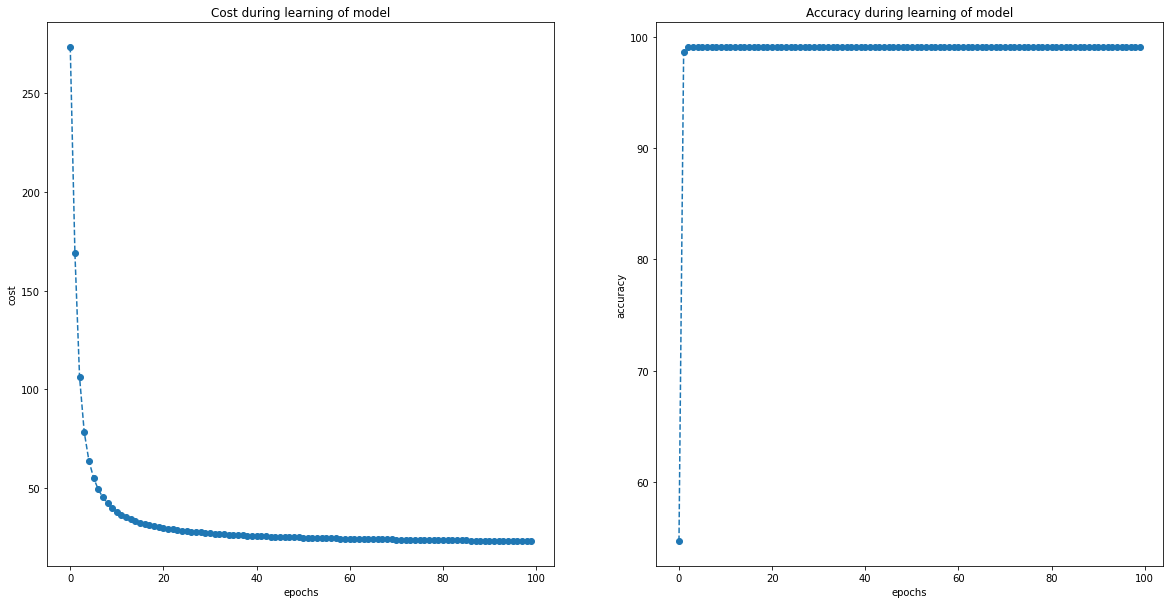

Accuracy of Test Dataset: 57.333333333333336 


In [5]:
#Zadanie 2
NFEATURES= 6
NCLASSES = 2
NSAMPLES = 300
X, y = make_classification(n_samples =NSAMPLES, n_features=NFEATURES, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=NCLASSES)
CLASSESNCOUNT = len(np.unique(y))
SAMPLESCOUNT = np.shape(X)[0]

yCoded = np.zeros((SAMPLESCOUNT,CLASSESNCOUNT))
iris_names = np.unique(y)
coded_list = [
                [1., 0.],
                [0., 1.],
             ]
for name, coded  in zip(iris_names, coded_list):
    yCoded[y == name] = coded
    
XTrain, XTest, yTrain, yTest = train_test_split(X, yCoded, random_state=13)
epochs =100
mlp = MLP(nfeatures=NFEATURES, nclasses=CLASSESNCOUNT,epochs = epochs) #Utworzenie modelu MLP
costOfEpoch, accuracyOfEpoch = mlp.fit(XTrain,yTrain)
drawLearningProcess(costOfEpoch, accuracyOfEpoch,epochs)
yPredicted = mlp.predict(XTest)
print("Accuracy of Test Dataset: {} ".format(mlp.accuracy_score(yTest, yPredicted)))

In [6]:
#ZADANIE 3 
from sklearn.preprocessing import MinMaxScaler


.....................................................................................
Learning Completed
Number of epochs: 100
Cost of last epoch: 78.60850728422459
Accuracy of last epoch: 96.42857142857143


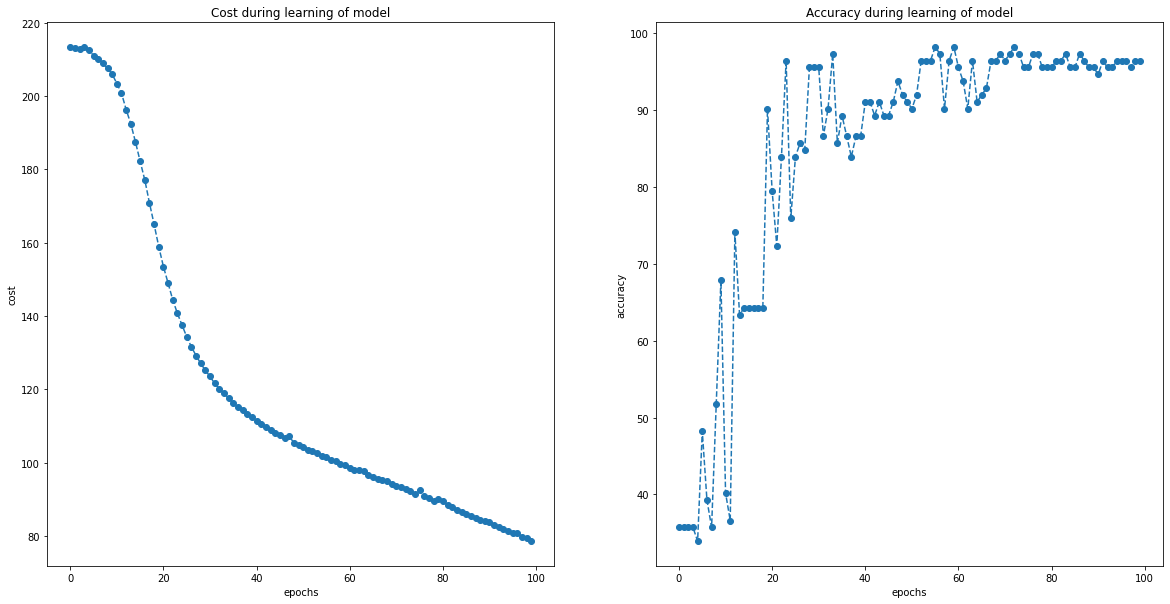

Accuracy of Test Dataset: 28.947368421052634 


In [10]:

NFEATURES= 4
scaler = MinMaxScaler()
X, y = fetch_openml(name="iris", version=1, return_X_y = True)
CLASSESNCOUNT = len(np.unique(y))
SAMPLESCOUNT = np.shape(X)[0]

yIrisCoded = np.zeros((SAMPLESCOUNT,CLASSESNCOUNT))
iris_names = np.unique(y)
coded_list = [
                [1., 0., 0.],
                [0., 1., 0.],
                [0., 0., 1.]
             ]
for name, coded  in zip(iris_names, coded_list):
    yIrisCoded[y == name] = coded

XScaled = scaler.fit_transform(X)    #normalizacja wejść
    
XTrain, XTest, yTrain, yTest = train_test_split(XScaled, yIrisCoded, random_state=13)
epochs =100
mlp = MLP(epochs = epochs) 
costOfEpoch, accuracyOfEpoch = mlp.fit(XTrain,yTrain)
drawLearningProcess(costOfEpoch, accuracyOfEpoch,epochs)
yPredicted = mlp.predict(XTest)
print("Accuracy of Test Dataset: {} ".format(mlp.accuracy_score(yTest, yPredicted)))

.....................................................................................
Learning Completed
Number of epochs: 100
Cost of last epoch: 101.0452255517758
Accuracy of last epoch: 93.77777777777779


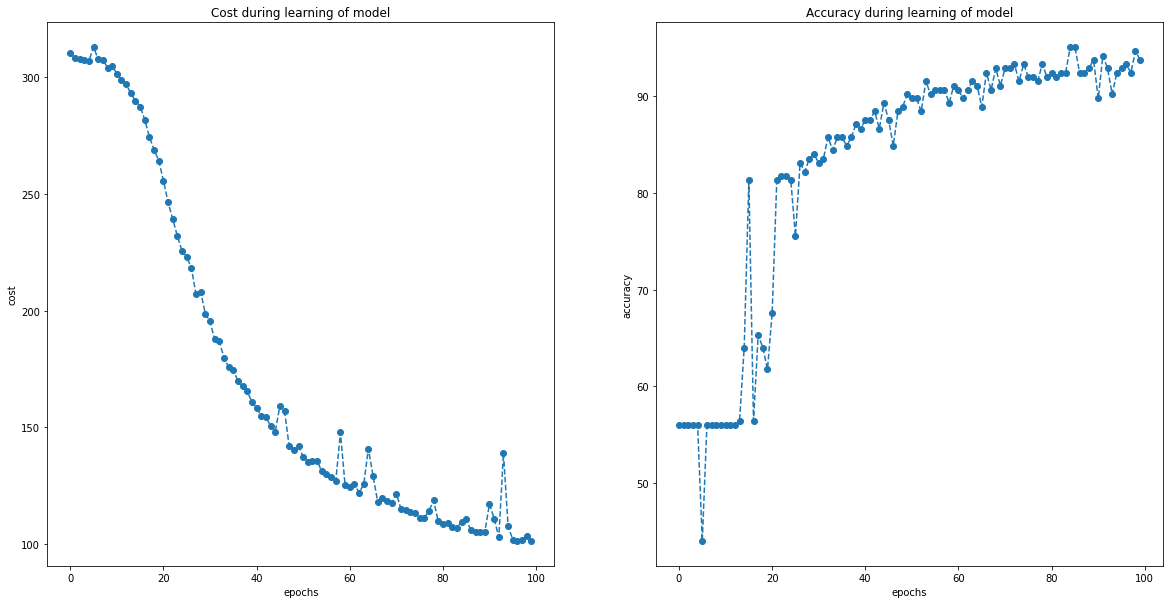

Accuracy of Test Dataset: 48.0 


In [13]:

NFEATURES= 6
NCLASSES = 2
NSAMPLES = 300
X, y = make_classification(n_samples =NSAMPLES, n_features=NFEATURES, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=NCLASSES)
CLASSESNCOUNT = len(np.unique(y))
SAMPLESCOUNT = np.shape(X)[0]

yCoded = np.zeros((SAMPLESCOUNT,CLASSESNCOUNT))
iris_names = np.unique(y)
coded_list = [
                [1., 0.],
                [0., 1.],
             ]
for name, coded  in zip(iris_names, coded_list):
    yCoded[y == name] = coded
    
scaler = MinMaxScaler()
XScaled = scaler.fit_transform(X) 

XTrain, XTest, yTrain, yTest = train_test_split(XScaled, yCoded, random_state=13)
epochs =100
mlp = MLP(nfeatures=NFEATURES, nclasses=CLASSESNCOUNT,epochs = epochs) #Utworzenie modelu MLP
costOfEpoch, accuracyOfEpoch = mlp.fit(XTrain,yTrain)
drawLearningProcess(costOfEpoch, accuracyOfEpoch,epochs)
yPredicted = mlp.predict(XTest)
print("Accuracy of Test Dataset: {} ".format(mlp.accuracy_score(yTest, yPredicted)))